<a href="https://colab.research.google.com/github/lebohangmolefe/Cataracts-Detection-Model/blob/main/CataractsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

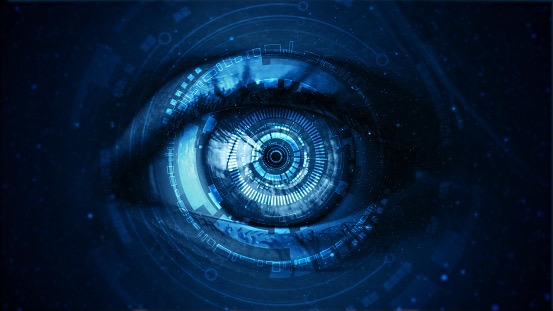

# Model Development

In [37]:
#Import colab drive to create and access folders from google drive

from  google.colab import drive

In [2]:
#Mount drive to gain access to google drive  

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#Install fastai2
#Import Fastai2 library

!pip install -Uq fastai2
import fastai2
from fastai2.vision import *

In [4]:
#Install Fastbook package in order to set up the Notebook
#Import all functions and classes from fastbook package and fastai vision widgets API

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

In [5]:
#Importing standard libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Aquisition (Collection and pre-processing)

In [6]:
#Creating path in Google drive where project is hosted
root_path = "gdrive/My Drive/DS_Projects"

In [7]:
#Creating "eyes" directory that will contain all images required
(Path(root_path)/"eyes").mkdir(parents=True, exist_ok = True)

In [8]:
#Creating folders for the eye types: Normal and Cataracts 

i_path = 'gdrive/My Drive/DS_Projects/eyes/'
folders = ["No cataracts", "Cataracts"]
for i in folders:
  path =Path(i_path)
  dest =(path/i).mkdir(parents=True,exist_ok = True)

In [9]:
#Define a list of Normal and Cataracts eyes
#Initialize the path where the images are located
#Allocate all the images from each folder into our path

eyes = "No cataracts", "Cataracts" 

path = 'gdrive/My Drive/DS_Projects/eyes/'

p_path = Path(path)

fns = get_image_files(path)
fns

(#264) [Path('gdrive/My Drive/DS_Projects/eyes/Cataracts/th (1).jpg'),Path('gdrive/My Drive/DS_Projects/eyes/Cataracts/th (6).jpg'),Path('gdrive/My Drive/DS_Projects/eyes/Cataracts/th (4).jpg'),Path('gdrive/My Drive/DS_Projects/eyes/Cataracts/th (5).jpg'),Path('gdrive/My Drive/DS_Projects/eyes/Cataracts/th.jpg'),Path('gdrive/My Drive/DS_Projects/eyes/Cataracts/th (9).jpg'),Path('gdrive/My Drive/DS_Projects/eyes/Cataracts/th (2).jpg'),Path('gdrive/My Drive/DS_Projects/eyes/Cataracts/th (8).jpg'),Path('gdrive/My Drive/DS_Projects/eyes/Cataracts/th (3).jpg'),Path('gdrive/My Drive/DS_Projects/eyes/Cataracts/th (7).jpg')...]

In [10]:
#Creating a Data Loaders class 
class DataLoaders(GetAttr):

  def __init_(self, *loaders): self.loaders = loaders
  def __getitem_(self, i): return self.loaders[i]
  train,valid = add_props(lambda i,self: self[i])

In [11]:
#Resizing to standard square size: 224*224 
#Split our dataset into training(80%) and validation(20%) sets
#Setting seed value to 24

eyes = DataBlock(blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  get_y=parent_label,
  item_tfms=Resize(224))

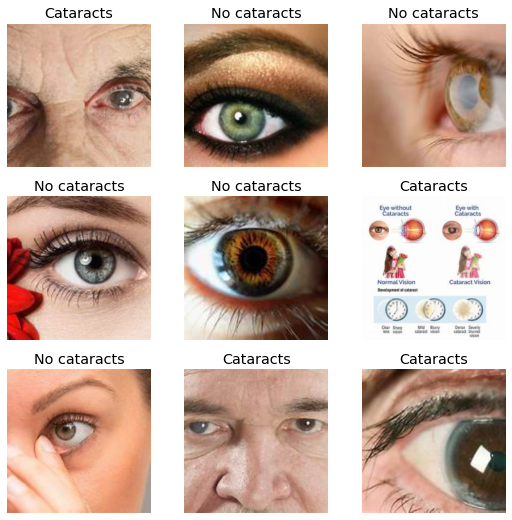

In [12]:
#Pass the data block to our data loaders class
#Create a dataloaders object and display a batch of sample images

dls = eyes.dataloaders(path)
dls.valid.show_batch(max_n=9, nrows=3)

In [13]:
#Create a convulutional neural network learner object
#Use resnet34 for Transfer Learning
#Train 8 Epochs of the model

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.425818,1.689912,0.480769,00:02
1,1.131122,0.530131,0.288462,00:02
2,0.934141,0.429045,0.173077,00:02
3,0.786586,0.373434,0.173077,00:02
4,0.703915,0.303166,0.153846,00:02
5,0.629012,0.267617,0.134615,00:02
6,0.567449,0.266134,0.096154,00:02
7,0.520375,0.270136,0.096154,00:02


In [14]:
#Save our model as "model_34"
learn.save("model_34")

Path('models/model_34.pth')

---

# Model Retraining

In [15]:
#Unfreeze to train the ends

learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time
0,0.202634,0.270905,0.096154,00:02
1,0.183213,0.279132,0.076923,00:02


SuggestedLRs(valley=0.00010964782268274575)

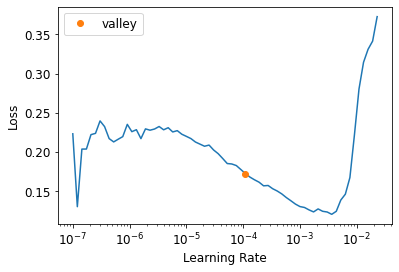

In [16]:
# fit whole model with new learning rates 
#learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4), wd=.001)

learn.fit_one_cycle(2, lr_max=slice(1e-6,1e-4))
learn.lr_find()

In [17]:
learn.freeze()

In [18]:
#Save the model as "model2_34"
learn.save('model2_34')

Path('models/model2_34.pth')

---

In [19]:
#Select the first model and load it

learn.load('model_34')


# Model performance

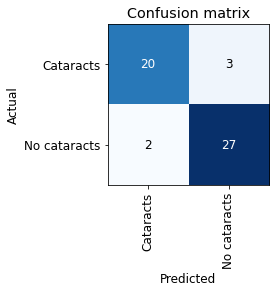

In [21]:
#Confusion matrix 

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

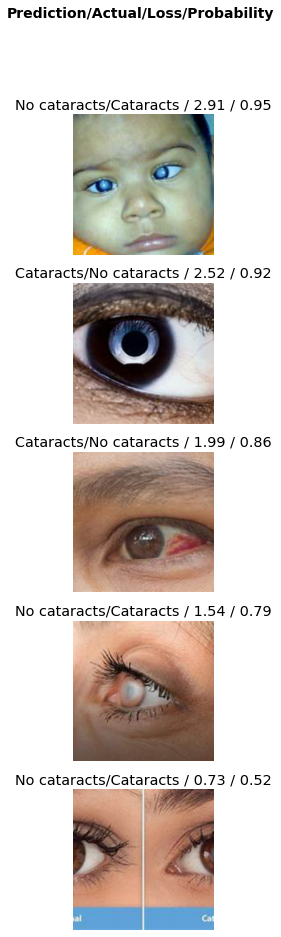

In [25]:
#View highest prediction loss images

interp.plot_top_losses(5,nrows = 5)

In [26]:
#Save our model, fastai will default save our model as "export.pkl" 

learn.export()
path = Path()
path.ls(file_exts='.pkl')


(#1) [Path('export.pkl')]

# Creating the Notebook app

In [27]:
#Load our model
#Access our data loaders for the prediction classes

learn_inf = load_learner(path/'export.pkl')
learn_inf.dls.vocab

['Cataracts', 'No cataracts']

# Graphical User Interface

In [28]:
#Create an upload button

btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [29]:
#Testing our upload button widget

btn_upload = SimpleNamespace(data = ["gdrive/MyDrive/DS_Projects/validcataracts/th (55).jpg"])
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [30]:
#Call our model using the "Predict method"
#output will consist of: Predicted output, the Predicted Class index  and the  Predicted Output probability

pred,pred_idx,probs = learn_inf.predict(img)

In [31]:
#Create  Label widget and initialize it to display our predictions 

lbl_pred = widgets.Label()
lbl_pred.value =f'{pred} eye detected ; Confidence: {probs[pred_idx]:.04f} Contact a medical professional for further assistance!'
lbl_pred

Label(value='Cataracts eye detected ; Confidence: 1.0000 Contact a medical professional for further assistance…

In [32]:
#Create our Classify Button

btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [34]:
#Define our classify Button

def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(224,224))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value =f'{pred} eye detected ; Probability: {probs[pred_idx]:.04f} Contact a medical professional for further assistance!'

btn_run.on_click(on_click_classify)

In [35]:
btn_upload = widgets.FileUpload()

In [36]:
#Arrange our GUI buttons for usage using the VBOX method

VBox([widgets.Label('Cataracts Dectection Application'), widgets.Label('Upload your image'),
      btn_upload, btn_run, out_pl, lbl_pred])